In [2]:
import torch

from retnet.configuration_retnet import RetNetConfig
from retnet.modeling_retnet import RetNetModel, RetNetModelWithLMHead

%load_ext autoreload
%autoreload 2

In [3]:
torch.manual_seed(0)
config = RetNetConfig(decoder_layers=6,
                      decoder_embed_dim=256,
                      decoder_retention_heads=4,
                      decoder_ffn_embed_dim=512)

model = RetNetModel(config)
model.eval()

device = 'cpu'  # cuda, cpu, mps for m1 mac
model = model.to(device)

## Test 1: Basic Equivalence of the 3 forward implementations

In [4]:
input_ids = torch.LongTensor([[1,2,1,2]]).to(device)

parallel_outputs = model(input_ids, forward_impl='parallel', use_cache=True)
parallel_state = parallel_outputs.last_hidden_state
parallel_cache = parallel_outputs.past_key_values

past_kv = None
rnn_state = []
for i in range(input_ids.shape[1]):
    rnn_out = model(input_ids[:, :i+1], forward_impl='recurrent', past_key_values=past_kv, use_cache=True)
    rnn_state.append(rnn_out.last_hidden_state)
    past_kv = rnn_out.past_key_values
rnn_state = torch.cat(rnn_state, dim=1)
rnn_cache = rnn_out.past_key_values


chunk_outputs = model(input_ids, forward_impl='chunkwise', use_cache=True, recurrent_chunk_size=2)
chunk_state = chunk_outputs.last_hidden_state
chunk_cache = chunk_outputs.past_key_values

print('parallel vs recurrent', torch.allclose(parallel_state, rnn_state, atol=1e-5))
print('parallel vs chunkwise', torch.allclose(parallel_state, chunk_state, atol=1e-5))

for i, (p, r, c) in enumerate(zip(parallel_cache, rnn_cache, chunk_cache)):
    print(f"layer: {i + 1}")
    key = 'prev_key_value'
    print('parallel vs recurrent:', torch.allclose(p[key], r[key], atol=1e-5))
    print('parallel vs chunkwise', torch.allclose(p[key], c[key], atol=1e-5))

parallel vs recurrent True
parallel vs chunkwise False
layer: 1
parallel vs recurrent: True
parallel vs chunkwise True
layer: 2
parallel vs recurrent: True
parallel vs chunkwise False
layer: 3
parallel vs recurrent: True
parallel vs chunkwise False
layer: 4
parallel vs recurrent: True
parallel vs chunkwise False
layer: 5
parallel vs recurrent: True
parallel vs chunkwise False
layer: 6
parallel vs recurrent: True
parallel vs chunkwise False


## Test 2: Retention Mask

Test both left padding / right padding

In [5]:
input_ids = torch.LongTensor([[1,2,3,4,1,2,5,5],
                              [5,5,1,2,3,4,1,2]]).to(device)
retention_mask = torch.LongTensor([[1,1,1,1,1,1,0,0],
                                   [0,0,1,1,1,1,1,1]]).to(device)

parallel_outputs = model(input_ids, retention_mask=retention_mask, forward_impl='parallel', use_cache=True)
parallel_state = parallel_outputs.last_hidden_state
parallel_cache = parallel_outputs.past_key_values

past_kv = None
rnn_state = []
for i in range(input_ids.shape[1]):
    rnn_out = model(input_ids[:, :i+1], retention_mask=retention_mask[:, i:i+1], forward_impl='recurrent', past_key_values=past_kv, use_cache=True)
    rnn_state.append(rnn_out.last_hidden_state)
    past_kv = rnn_out.past_key_values
rnn_state = torch.cat(rnn_state, dim=1)
rnn_cache = rnn_out.past_key_values


chunk_outputs = model(input_ids, retention_mask=retention_mask, forward_impl='chunkwise', use_cache=True, recurrent_chunk_size=4)
chunk_state = chunk_outputs.last_hidden_state
chunk_cache = chunk_outputs.past_key_values

mask = retention_mask.unsqueeze(-1).float()
print('parallel vs recurrent:', torch.allclose(parallel_state * mask, rnn_state * mask, atol=1e-5))
print('parallel vs chunkwise', torch.allclose(parallel_state * mask, chunk_state * mask, atol=1e-5))

for i, (p, r, c) in enumerate(zip(parallel_cache, rnn_cache, chunk_cache)):
    print(f"layer: {i + 1}")
    key = 'prev_key_value'
    print('parallel vs recurrent:', torch.allclose(p[key], r[key], atol=1e-5))
    print('parallel vs chunkwise', torch.allclose(p[key], c[key], atol=1e-5))


parallel vs recurrent: True
parallel vs chunkwise False
layer: 1
parallel vs recurrent: True
parallel vs chunkwise False
layer: 2
parallel vs recurrent: True
parallel vs chunkwise False
layer: 3
parallel vs recurrent: True
parallel vs chunkwise False
layer: 4
parallel vs recurrent: True
parallel vs chunkwise False
layer: 5
parallel vs recurrent: True
parallel vs chunkwise False
layer: 6
parallel vs recurrent: True
parallel vs chunkwise False


## Test 3: Generate

In [6]:
input_ids = torch.LongTensor([[1,2,3,4,5,6,7,8],
                              [8,7,6,5,4,3,2,1]]).to(device)
model = RetNetModelWithLMHead(config).to(device)
model.eval()

# greedy
p_generated = model.generate(input_ids, parallel_compute_prompt=True, max_new_tokens=20, do_sample=False, early_stopping=False)
r_generated = model.generate(input_ids, parallel_compute_prompt=False, max_new_tokens=20, do_sample=False, early_stopping=False)
print((p_generated == r_generated).all())

# sampling
torch.manual_seed(0)
p_generated = model.generate(input_ids, parallel_compute_prompt=True, max_new_tokens=20, do_sample=True, early_stopping=False)
torch.manual_seed(0)
r_generated = model.generate(input_ids, parallel_compute_prompt=False, max_new_tokens=20, do_sample=True, early_stopping=False)
print((p_generated == r_generated).all())



tensor(True)
tensor(True)


## Test 4: Forgetting (Long sequence dependency)

In [7]:
config = RetNetConfig(decoder_layers=6,
                      decoder_embed_dim=256,
                      decoder_retention_heads=4,
                      decoder_ffn_embed_dim=512)

model = RetNetModel(config)
model.eval();

In [8]:
i = 256
effective_seqlen = []
for e in range(6):
    non_zero_start = torch.where(model.retnet_rel_pos(i)[1][0][0, 0, -1] > 0)[0][0]
    effective_seqlen.append(i - non_zero_start.item())
    i *= 2

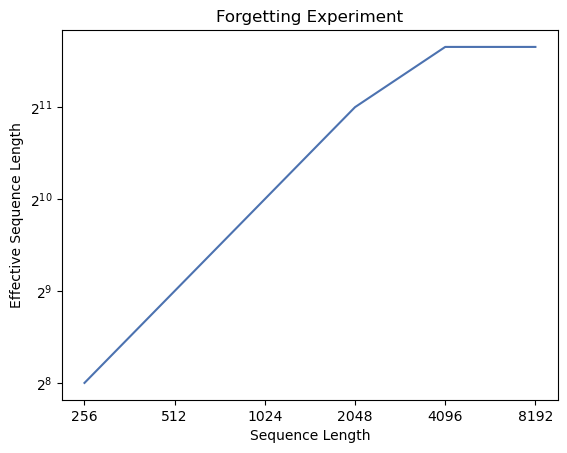

In [9]:
import matplotlib.pyplot as plt

x = [2 ** (8 + i) for i in range(6)]

plt.title("Forgetting Experiment")
plt.loglog(x, effective_seqlen, base=2)
plt.xticks(x, x)
plt.xlabel("Sequence Length")
plt.ylabel("Effective Sequence Length");

In [10]:
effective_seqlen

[256, 512, 1024, 2048, 3225, 3225]

## Inference Time Test

In [11]:
import time

model = RetNetModel(config).to(device)
model.eval()

parallel_history = []
recurrent_history = []

sequence_lengths = [256, 512, 1024, 2048, 4096]
for seqlen in sequence_lengths:
    print("#" * 30, f"seqlen: {seqlen}", "#" * 30)
    input_ids = torch.ones(1, seqlen).long().to(device)
    start = time.time()
    parallel_outputs = model(input_ids, forward_impl='parallel', use_cache=True)
    past_kv = parallel_outputs.past_key_values
    parallel_time = time.time() - start
    print(f"parallel: {parallel_time}")
    parallel_history.append(parallel_time)

    start = time.time()
    rnn_out = model(input_ids, forward_impl='recurrent', past_key_values=past_kv, use_cache=True)
    recurrent_time = time.time() - start
    print(f"recurrent: {recurrent_time}")
    recurrent_history.append(recurrent_time)



############################## seqlen: 256 ##############################
parallel: 0.049674034118652344
recurrent: 0.0034019947052001953
############################## seqlen: 512 ##############################
parallel: 0.10489201545715332
recurrent: 0.005728006362915039
############################## seqlen: 1024 ##############################
parallel: 0.24175691604614258
recurrent: 0.005491018295288086
############################## seqlen: 2048 ##############################
parallel: 0.5037298202514648
recurrent: 0.007761240005493164
############################## seqlen: 4096 ##############################
parallel: 1.369204044342041
recurrent: 0.014892101287841797


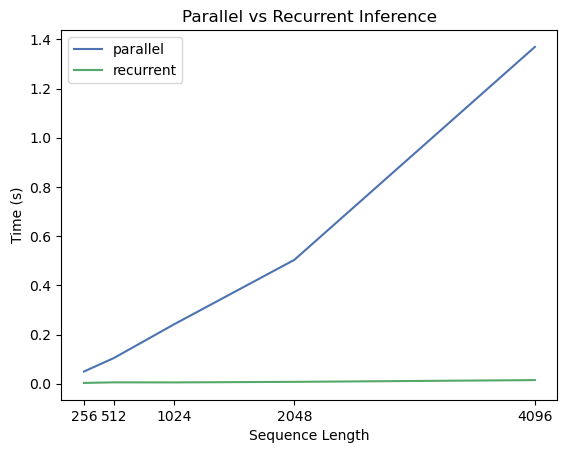

In [16]:
plt.plot(sequence_lengths, parallel_history, label='parallel')
plt.plot(sequence_lengths, recurrent_history, label='recurrent')
plt.xticks(sequence_lengths, sequence_lengths)
plt.legend()
plt.xlabel("Sequence Length")
plt.ylabel("Time (s)")
plt.title("Parallel vs Recurrent Inference");